In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from resources.plotting import Plotter
from tqdm.autonotebook import tqdm

from nltk.tokenize import WordPunctTokenizer

from nltk.translate.bleu_score import sentence_bleu
from rouge_score.rouge_scorer import RougeScorer
from resources.bart_score import BARTScorer
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
MODELS = {
    "Gemma 1.1 - 2B":  "google/gemma-1.1-2b-it",
    "Gemma 1.1 - 7B":  "google/gemma-1.1-7b-it",
    "Gemma 2.0 - 9B":  "google/gemma-2-9b-it",
    "Gemma 2.0 - 27B": "google/gemma-2-27b-it",
    "Llama 3.1 - 8B":  "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "Llama 3.1 - 70B": "meta-llama/Meta-Llama-3.1-70B-Instruct",
    "Llama 3.2 - 1B":  "meta-llama/Llama-3.2-1B-Instruct",
    "Llama 3.2 - 3B":  "meta-llama/Llama-3.2-3B-Instruct",
    "Llama 3.3 - 70B": "meta-llama/Llama-3.3-70B-Instruct",
    "Falcon 1.0 - 7B": "tiiuae/Falcon-7B-Instruct",
    "Falcon 3.0 - 3B": "tiiuae/Falcon3-3B-Instruct",
    "Falcon 3.0 - 7B": "tiiuae/Falcon3-7B-Instruct",
    "Falcon 3.0 - 10B": "tiiuae/Falcon3-10B-Instruct"
}
LABELS = np.array(['allergens', 'biological', 'foreign bodies', 'chemical', 'organoleptic aspects', 'fraud'], dtype=object)
K = 10
PLOTS_DIR  = "plots"

# Load results:

In [3]:
RESULTS = {}

for key in MODELS:
    t_start = time.time()
    with open(f'results/food incidents - hazard/{MODELS[key]}-self-counterfactuals.pkl', 'rb') as file:
        RESULTS[key] = pickle.load(file)
    print(f'Loaded {key} ({len(RESULTS[key]):d} instances, dt={(time.time()-t_start)*1000:.2f} ms).')

Loaded Gemma 1.1 - 2B (200 instances, dt=11361.68 ms).
Loaded Gemma 1.1 - 7B (200 instances, dt=8712.68 ms).
Loaded Gemma 2.0 - 9B (200 instances, dt=24.44 ms).
Loaded Gemma 2.0 - 27B (200 instances, dt=22.93 ms).
Loaded Llama 3.1 - 8B (200 instances, dt=20.84 ms).
Loaded Llama 3.1 - 70B (200 instances, dt=14.80 ms).
Loaded Llama 3.2 - 1B (200 instances, dt=28.10 ms).
Loaded Llama 3.2 - 3B (200 instances, dt=27.17 ms).
Loaded Llama 3.3 - 70B (200 instances, dt=261.23 ms).
Loaded Falcon 1.0 - 7B (200 instances, dt=28.97 ms).
Loaded Falcon 3.0 - 3B (200 instances, dt=21.98 ms).
Loaded Falcon 3.0 - 7B (200 instances, dt=15.64 ms).
Loaded Falcon 3.0 - 10B (200 instances, dt=15.22 ms).


In [4]:
plotter = Plotter(RESULTS, i_sample=8, save_dir=PLOTS_DIR)
plotter.print_chat("Llama 3.1 - 8B")

\begin{tabular}{p{.05\linewidth}p{.1\linewidth}p{.8\linewidth}}

\hline

&
\textbf{user}: &
\texttt{What is the reason for the recall of the food product in the following announcement?

"Sainsbury's recalls all codes of its own brand So Organic Fruit and Nut Mix due to salmonella contamination"

Assign one of the following labels: "biological", "allergens", "chemical", "foreign bodies", "organoleptic aspects", or "fraud". Make sure to answer only with the label or "none" if none of them applies.} \\

&
\textbf{assistant}: &
\texttt{biological} \\


\hline

\end{tabular}


# Performance:

In [5]:
for model in RESULTS:
    y_true = np.array([''.join(item['label']['tokens']) for item in RESULTS[model]])
    y_pred = np.array([''.join(item['prediction']['text']) for item in RESULTS[model]])

    ls = np.unique(y_true)
    y_true = np.array([y_true == l for l in ls]).T
    y_pred = np.array([y_pred == l for l in ls]).T
    
    print(model)
    print(f'  F1:           {f1_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  precision:    {precision_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  recall:       {recall_score(y_true, y_pred, average="macro"):.2f}')
    print()

Gemma 1.1 - 2B
  F1:           0.28
  precision:    0.42
  recall:       0.22

Gemma 1.1 - 7B
  F1:           0.48
  precision:    0.61
  recall:       0.48

Gemma 2.0 - 9B
  F1:           0.53
  precision:    0.63
  recall:       0.51

Gemma 2.0 - 27B
  F1:           0.53
  precision:    0.62
  recall:       0.51

Llama 3.1 - 8B
  F1:           0.44
  precision:    0.43
  recall:       0.45

Llama 3.1 - 70B
  F1:           0.51
  precision:    0.64
  recall:       0.51

Llama 3.2 - 1B
  F1:           0.02
  precision:    0.18
  recall:       0.01

Llama 3.2 - 3B
  F1:           0.17
  precision:    0.46
  recall:       0.12

Llama 3.3 - 70B
  F1:           0.54
  precision:    0.64
  recall:       0.53

Falcon 1.0 - 7B
  F1:           0.05
  precision:    0.12
  recall:       0.03

Falcon 3.0 - 3B
  F1:           0.23
  precision:    0.43
  recall:       0.17

Falcon 3.0 - 7B
  F1:           0.45
  precision:    0.60
  recall:       0.44

Falcon 3.0 - 10B
  F1:           0.47
  precis

/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/

# Self assessment:

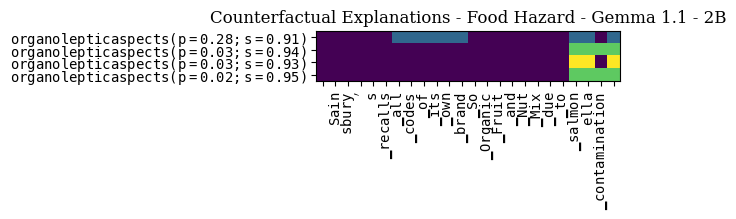

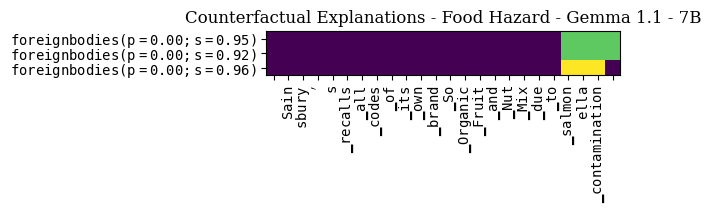

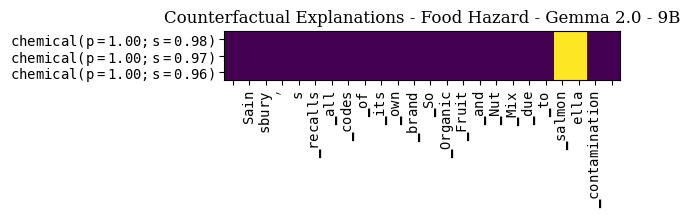

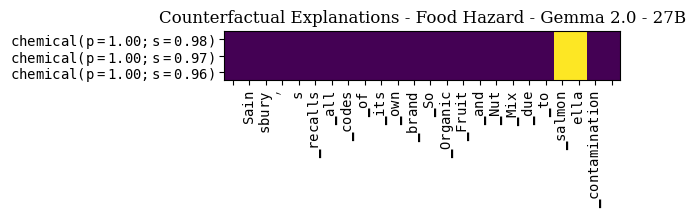

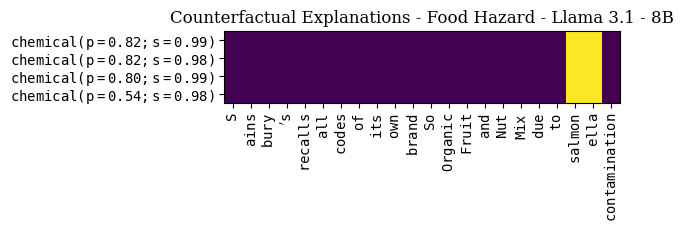

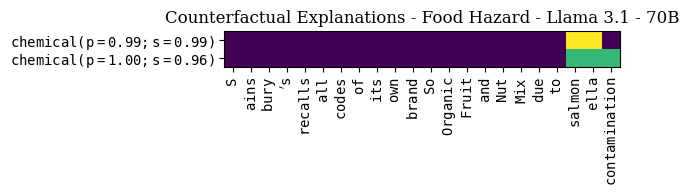

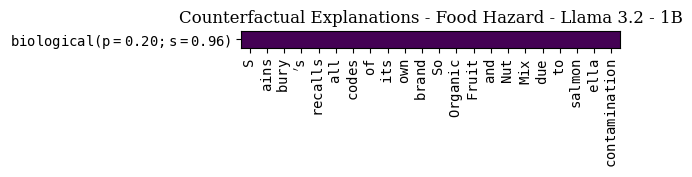

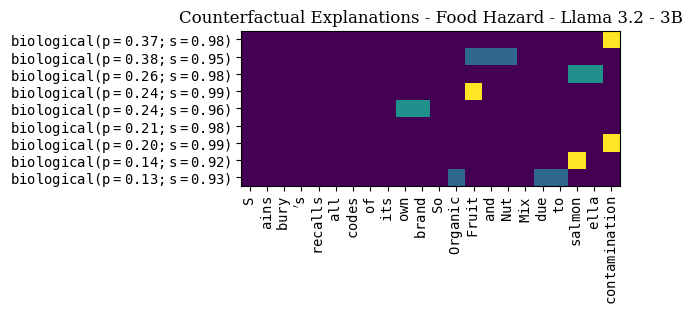

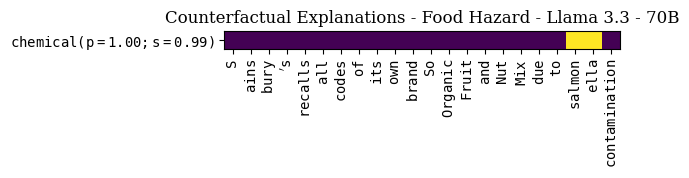

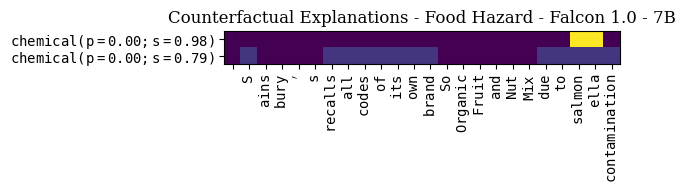

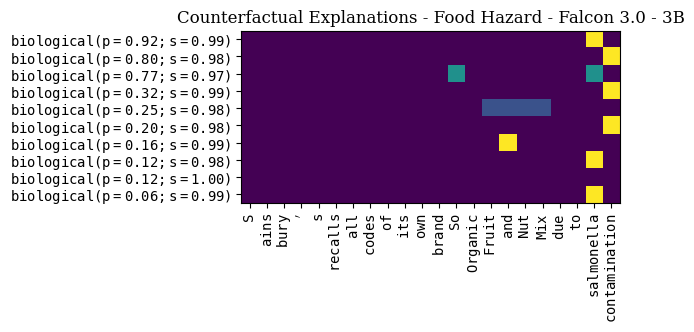

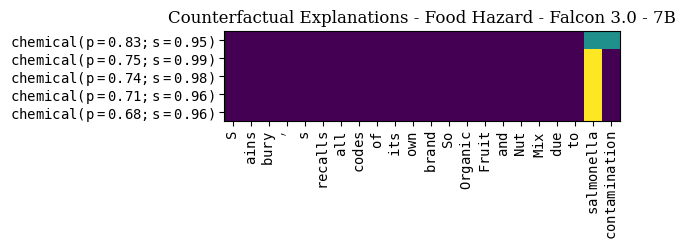

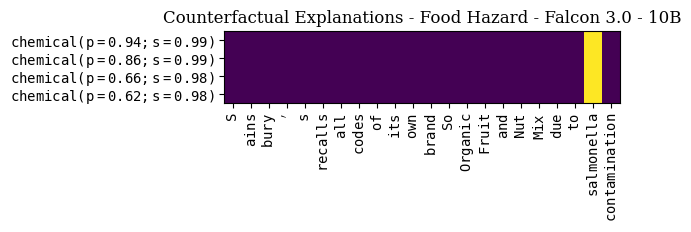

In [6]:
importance_cf = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']

        label_probs = [(label, r['counterfactuals'][label]['probability']) for label in r['counterfactuals']]
        label_probs.sort(key=lambda x: x[1], reverse=True)

        for cf_label, cf_probability in label_probs:
            probabilities = np.array([float(s['probability']) for s in r['counterfactuals'][cf_label]['samples']])
            similarities  = np.array([float(s['similarity']) for s in r['counterfactuals'][cf_label]['samples']])
            success       = np.array([cf_label in s['prediction'] for s in r['counterfactuals'][cf_label]['samples']])

            if success.any(): break

        importance_cf[model].append({})
        for i in np.argsort(probabilities*similarities*success.astype(bool))[::-1]:
            if not success[i]: continue

            cf = r['counterfactuals'][cf_label]['samples'][i]

            importance = np.zeros(length, dtype=float)
            for j,k in cf['spans']:
                importance[j-offset:k-offset] = 1.
            importance /= max(importance.sum(), 1e-9)

            importance_cf[model][-1][f'{cf_label} (p={probabilities[i]:.2f}; s={similarities[i]:.2f})'] = importance

plotter.plot_importance([importance_cf], [''], f'Counterfactual Explanations - Food Hazard')

### Produce best CF@$k$:

In [7]:
wp_tokenizer = WordPunctTokenizer()
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=wp_tokenizer)
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

counterfactuals  = {model:{i+1: [] for i in range(K)} for model in RESULTS}
path = 'results/food incidents - hazard/counterfactuals/'
os.makedirs(path, exist_ok=True)

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']

        label_probs = [(label, r['counterfactuals'][label]['probability']) for label in r['counterfactuals']]
        label_probs.sort(key=lambda x: x[1], reverse=True)

        dt = [0.]
        for cl, (cf_label, cf_probability) in enumerate(label_probs):
            probabilities = np.array([float(s['probability']) for s in r['counterfactuals'][cf_label]['samples']])
            similarities  = np.array([float(s['similarity']) for s in r['counterfactuals'][cf_label]['samples']])
            dt            = dt[-1] + np.cumsum([float(s['dt']) * 1e-9 for s in r['counterfactuals'][cf_label]['samples']])
            success       = np.array([cf_label in s['prediction'] for s in r['counterfactuals'][cf_label]['samples']])

            if success.any(): break

        scores  = probabilities*similarities
        for i in range(K):
            if not success[:i+1].any(): j = np.argmax(scores[:i+1])
            else: j = np.argmax((scores - np.where(success, 0., np.inf))[:i+1])

            text = r['counterfactuals'][cf_label]['samples'][j]['text']
            bleu = sentence_bleu([wp_tokenizer.tokenize(r['sample']['text'].lower())], wp_tokenizer.tokenize(text.lower()))
            rouge = rouge_scorer.score(r['sample']['text'].lower(), text.lower())
            bart = bart_scorer.score([r['sample']['text']], [text.lower()], batch_size=4)

            counterfactuals[model][i+1].append({
                'text':        text,
                'prediction':  cf_label,
                'success':     success[j],
                'probability': probabilities[j],
                'similarity':  similarities[j],
                'bleu':        bleu,
                'rouge1-rec':  rouge['rouge1'].recall,
                'rouge1-prc':  rouge['rouge1'].precision,
                'rouge1-f1':   rouge['rouge1'].fmeasure,
                'rougeL-rec':  rouge['rougeL'].recall,
                'rougeL-prc':  rouge['rougeL'].precision,
                'rougeL-f1':   rouge['rougeL'].fmeasure,
                'bart-score':  bart[0],
                'spans':       r['counterfactuals'][cf_label]['samples'][j]['spans'],
                'dt':          dt[i] if i < len(dt) else np.nan,
                'best':        float(j),
                'best_class':  cl
            })

    for i in counterfactuals[model]:
        counterfactuals[model][i] = pd.DataFrame(counterfactuals[model][i])
        counterfactuals[model][i].to_csv(path + f'{model}-first{i:d}.csv')

/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

### OR load best CF@$k$:

In [7]:
counterfactuals  = {model:{i+1: [] for i in range(K)} for model in RESULTS}
path = 'results/food incidents - hazard/counterfactuals/'

for model in RESULTS:
    for i in counterfactuals[model]:
        counterfactuals[model][i] = pd.read_csv(path + f'{model}-first{i:d}.csv')

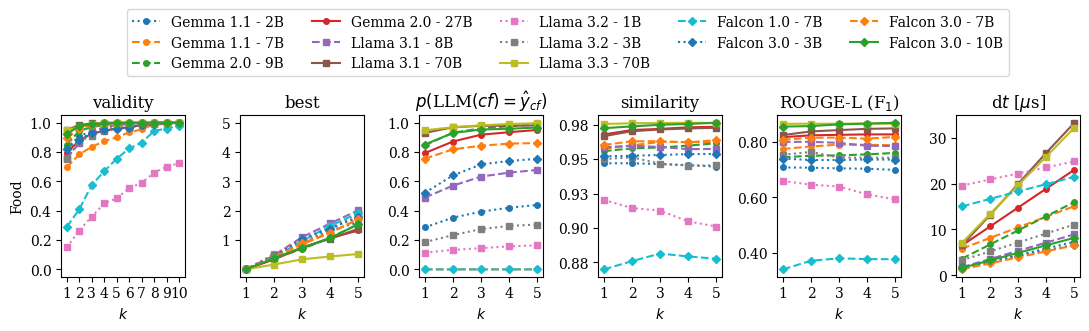

In [8]:
fig, axs = plt.subplots(1, 6, figsize=(11,3.5))
xs = np.arange(5)+1

markers = ['o']*4 + ['s']*5 + ['D']*4

for marker, model in zip(markers, RESULTS):
    size = int(model.split()[-1][:-1])
    if size <= 3:   linestyle = ':'
    elif size <= 9: linestyle = '--'
    else:           linestyle = '-'

    val  = [counterfactuals[model][i+1]['success'].mean() for i in range(K)]
    axs[0].plot(np.arange(K)+1, val, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[0].set_xticks(np.arange(K)+1)
    axs[0].set_xlabel('$k$')
    axs[0].set_title('validity')
    axs[0].set_ylim(-.05, 1.05)
    axs[0].set_yticks([0., .2, .4, .6, .8 , 1.])

    best  = [counterfactuals[model][i+1]['best'][counterfactuals[model][i+1]['success']].mean() for i in range(5)]
    axs[1].plot(xs, best, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[1].set_title('best')
    axs[1].set_ylim(-.25, 5.25)
    axs[1].set_yticks(xs)

    prob = [counterfactuals[model][i+1]['probability'].mean() for i in range(5)]
    axs[2].plot(xs, prob, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[2].set_title('$p($LLM$(cf) = \\hat{y}_{cf})$')
    axs[2].set_ylim(-.05, 1.05)
    axs[2].set_yticks([0., .2, .4, .6, .8 , 1.])

    sim  = [counterfactuals[model][i+1]['similarity'].mean() for i in range(5)]
    axs[3].plot(xs, sim, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[3].set_title('similarity')
    axs[3].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:.2f}')
    )

    sim  = [counterfactuals[model][i+1]['rougeL-f1'].mean() for i in range(5)]
    axs[4].plot(xs, sim, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[4].set_title('ROUGE-L (F$_1$)')
    axs[4].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:.2f}')
    )

    dt   = [counterfactuals[model][i+1]['dt'].mean() for i in range(5)]
    axs[5].plot(xs, dt, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[5].set_title('d$t$ [$\mu$s]')
    axs[5].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:.0f}')
    )

for ax in axs[1:]:
    ax.set_xticks(xs)
    ax.set_xlabel('$k$')

axs[0].set_ylabel('Food')

plt.tight_layout(rect=(0, 0, 1, .75))
axs[2].legend(bbox_to_anchor=(.7, 1.2, 1, 1), loc='lower center', ncols=len(RESULTS)//3+1)
plt.savefig('plots/Counterfactuals-FoodHazard.pdf')
plt.show()

## First candidiate:

In [9]:
for model in counterfactuals: print(model, '\n', counterfactuals[model][1].describe(), '\n')

Gemma 1.1 - 2B 
        Unnamed: 0   probability  similarity           bleu  rouge1-rec  \
count  200.000000  2.000000e+02  200.000000   2.000000e+02  200.000000   
mean    99.500000  2.863203e-01    0.946976   5.631217e-01    0.742462   
std     57.879185  2.728546e-01    0.030927   1.964846e-01    0.133257   
min      0.000000  5.611219e-08    0.824645  4.873718e-155    0.250000   
25%     49.750000  1.086426e-02    0.931573   4.313250e-01    0.666667   
50%     99.500000  2.456055e-01    0.952606   5.808970e-01    0.769231   
75%    149.250000  4.682617e-01    0.967391   7.118329e-01    0.850000   
max    199.000000  9.726562e-01    1.000000   9.374116e-01    0.941176   

       rouge1-prc   rouge1-f1  rougeL-rec  rougeL-prc   rougeL-f1  bart-score  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.695999    0.710302    0.739564    0.693122    0.707448   -2.310030   
std      0.167347    0.139476    0.134150    0.167258    0.139965    0.65

                & Validity & $k@\epsilon=1e-9$ & Probability & Similarity & BLEU & ROUGE-1 & ROUGE-L & BARTScore &    dt \\
Gemma 1.1 - 2B  &     0.82 &                12 &        0.34 &       0.95 &   0.56 &    0.70 &    0.70 &      0.12 &  1.46 \\
Gemma 1.1 - 7B  &     0.69 &                18 &        0.00 &       0.96 &   0.67 &    0.77 &    0.77 &      0.11 &  3.99 \\
Gemma 2.0 - 9B  &     0.85 &                11 &        0.99 &       0.96 &   0.64 &    0.74 &    0.74 &      0.03 &  3.74 \\
Gemma 2.0 - 27B &     0.80 &                14 &        0.99 &       0.97 &   0.73 &    0.82 &    0.81 &      0.08 &  6.86 \\
Llama 3.1 - 8B  &     0.76 &                15 &        0.63 &       0.96 &   0.69 &    0.81 &    0.80 &      0.09 &  1.73 \\
Llama 3.1 - 70B &     0.95 &                 7 &        0.97 &       0.97 &   0.74 &    0.83 &    0.83 &      0.08 &  6.51 \\
Llama 3.2 - 1B  &     0.15 &               128 &        0.24 &       0.91 &   0.40 &    0.60 &    0.57 &      0.06 &  5.

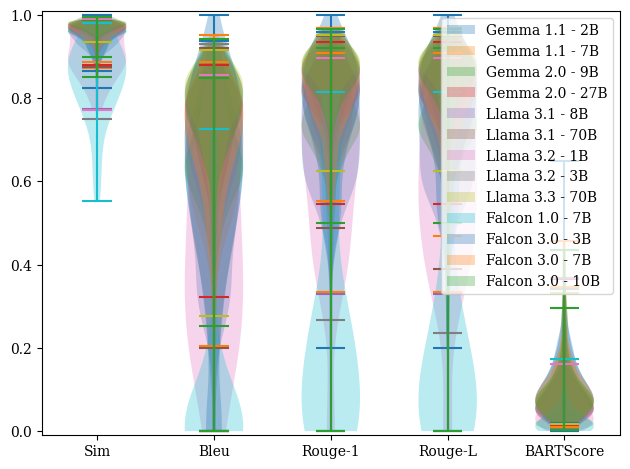

In [10]:
hs, ls = [], []

print(f'{" "*15} & Validity & $k@\epsilon=1e-9$ & Probability & Similarity & BLEU & ROUGE-1 & ROUGE-L & BARTScore &    dt \\\\')
for model in counterfactuals:
    cf = counterfactuals[model][1].copy()
    cf['bart-score'] = np.exp(cf['bart-score'].values)
    
    hs.append(plt.violinplot(cf[['similarity', 'bleu', 'rouge1-f1', 'rougeL-f1', 'bart-score']][cf.success.values].values)['bodies'][0])
    ls.append(model)

    print(f'{model}{" "*(15-len(model))} & ' +
        f'{cf["success"].values.mean():8.2f} & ' +
        f'{np.ceil(np.emath.logn((1 - cf.success.values.mean()), 1e-9)):17.0f} & ' +
        f'{cf["probability"][cf.success.values].mean():11.2f} & ' +
        f'{cf["similarity"][cf.success.values].mean():10.2f} & ' +
        f'{cf["bleu"][cf.success.values].mean():6.2f} & ' +
        f'{cf["rouge1-f1"][cf.success.values].mean():7.2f} & ' +
        f'{cf["rougeL-f1"][cf.success.values].mean():7.2f} & ' +
        f'{cf["bart-score"][cf.success.values].mean():9.2f} & ' +
        f'{cf["dt"][cf.success.values].mean():5.2f} \\\\'
    )

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=['Sim', 'Bleu', 'Rouge-1', 'Rouge-L', 'BARTScore'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

## Best successfull cf:

In [11]:
for model in counterfactuals: print(model, '\n', counterfactuals[model][5].describe(), '\n')

Gemma 1.1 - 2B 
        Unnamed: 0  probability  similarity           bleu  rouge1-rec  \
count  200.000000   200.000000  200.000000   2.000000e+02  200.000000   
mean    99.500000     0.439475    0.944540   5.572898e-01    0.729060   
std     57.879185     0.284100    0.029002   1.727758e-01    0.124143   
min      0.000000     0.000157    0.828283  4.873718e-155    0.285714   
25%     49.750000     0.214355    0.930184   4.460389e-01    0.666667   
50%     99.500000     0.458008    0.950386   5.694800e-01    0.736842   
75%    149.250000     0.661133    0.964194   7.012055e-01    0.818182   
max    199.000000     0.972656    0.991228   9.374116e-01    0.939394   

       rouge1-prc   rouge1-f1  rougeL-rec  rougeL-prc   rougeL-f1  bart-score  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.687567    0.702216    0.725441    0.684158    0.698710   -2.404872   
std      0.147679    0.126109    0.124301    0.147672    0.126076    0.619556   
m

                & Validity & Probability & Similarity & BLEU & ROUGE-1 & ROUGE-L & BARTScore &    dt \\
Gemma 1.1 - 2B  &     0.98 &        0.45 &       0.94 &   0.56 &    0.73 &    0.72 &      0.11 &  7.34 \\
Gemma 1.1 - 7B  &     0.90 &        0.00 &       0.96 &   0.69 &    0.81 &    0.81 &      0.11 & 14.08 \\
Gemma 2.0 - 9B  &     0.99 &        0.99 &       0.96 &   0.66 &    0.79 &    0.79 &      0.04 & 15.98 \\
Gemma 2.0 - 27B &     0.96 &        0.99 &       0.97 &   0.74 &    0.81 &    0.81 &      0.09 & 23.13 \\
Llama 3.1 - 8B  &     0.98 &        0.69 &       0.96 &   0.68 &    0.82 &    0.81 &      0.08 &  8.97 \\
Llama 3.1 - 70B &     1.00 &        0.98 &       0.97 &   0.75 &    0.83 &    0.83 &      0.09 & 33.24 \\
Llama 3.2 - 1B  &     0.48 &        0.26 &       0.89 &   0.39 &    0.79 &    0.74 &      0.07 &  9.57 \\
Llama 3.2 - 3B  &     0.97 &        0.31 &       0.95 &   0.58 &    0.86 &    0.85 &      0.08 & 11.01 \\
Llama 3.3 - 70B &     1.00 &        1.00 &      

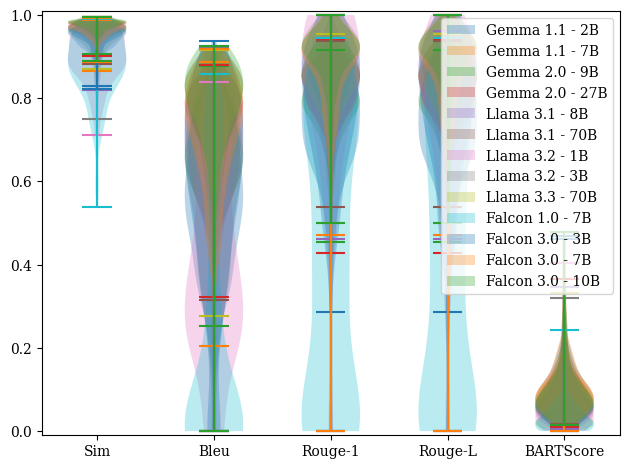

In [12]:
hs, ls = [], []

print(f'{" "*15} & Validity & Probability & Similarity & BLEU & ROUGE-1 & ROUGE-L & BARTScore &    dt \\\\')
for model in counterfactuals:
    cf = counterfactuals[model][5].copy()
    cf['bart-score'] = np.exp(cf['bart-score'].values)
    
    hs.append(plt.violinplot(cf[['similarity', 'bleu', 'rouge1-rec', 'rougeL-rec', 'bart-score']][cf.success.values].values)['bodies'][0])
    ls.append(model)

    print(f'{model}{" "*(15-len(model))} & ' +
        f'{cf["success"].values.mean():8.2f} & ' +
        f'{cf["probability"][cf.success.values].mean():11.2f} & ' +
        f'{cf["similarity"][cf.success.values].mean():10.2f} & ' +
        f'{cf["bleu"][cf.success.values].mean():6.2f} & ' +
        f'{cf["rouge1-rec"][cf.success.values].mean():7.2f} & ' +
        f'{cf["rougeL-rec"][cf.success.values].mean():7.2f} & ' +
        f'{cf["bart-score"][cf.success.values].mean():9.2f} & ' +
        f'{cf["dt"][cf.success.values].mean():5.2f} \\\\'
    )

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=['Sim', 'Bleu', 'Rouge-1', 'Rouge-L', 'BARTScore'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

# Statistical Tests:

$p$-value < $\alpha~\rightarrow$ reject $H_0$

Used tests:
 - Shapiro-Wilk: $H_0$ = "`a` is normally distributed."
 - Wilcoxon signed-rank test: $H_0$ = "`a`-`b` is symmetric about $\mu = 0$."

In [13]:
from scipy.stats import shapiro, wilcoxon

In [14]:
def normality_of_differnces(a, b, alpha=.05):
    W, p = shapiro(a-b)
    return p > alpha, 'There is' + (' NO ' if p > alpha else ' ') + f'evidence that the differences are not normally distributed (%alpha={alpha:.2f}, p={p:.3f})'
    

In [15]:
ALPHA = 0.05

## 1. Best better than First:

In [16]:
dt_analysis = {}
for model in RESULTS:
    dt_first = counterfactuals[model][1]['dt'].values
    dt_best  = counterfactuals[model][5]['dt'].values

    # first vs. best:
    normal, msg = normality_of_differnces(dt_first, dt_best, alpha=ALPHA)
    print(f'{model}: {msg}')
    
    t, p = wilcoxon(dt_first, dt_best, alternative='less')

    dt_analysis[model] = {
        '$min_{first}$': f'{dt_first.min():.2f}', '$\mu_{first}$': f'{dt_first.mean():.2f}', '$max_{first}$': f'{dt_first.max():.2f}',
        '$min_{best}$': f'{dt_best.min():.2f}',   '$\mu_{best}$': f'{dt_best.mean():.2f}',   '$max_{best}$': f'{dt_best.max():.2f}',
        '$dt_{first}~<~dt_{best}$': (p < ALPHA),
        '$p-value~(dt_{first}~<~dt_{best})$': f'{p:.3f}',
    }

dt_analysis = pd.DataFrame(dt_analysis).T

dt_analysis

Gemma 1.1 - 2B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.007)
Gemma 1.1 - 7B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 9B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 27B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 8B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.2 - 1B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.2 - 3B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.3 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Falcon 1.0 - 7B: There is evidence

,$min_{first}$,$\mu_{first}$,$max_{first}$,$min_{best}$,$\mu_{best}$,$max_{best}$,$dt_{first}~<~dt_{best}$,$p-value~(dt_{first}~<~dt_{best})$
Gemma 1.1 - 2B,1.16,1.46,1.87,5.91,7.34,9.67,True,0.000
Gemma 1.1 - 7B,1.87,5.83,63.14,9.41,15.08,74.37,True,0.000
Gemma 2.0 - 9B,2.19,3.66,36.67,10.80,15.99,49.59,True,0.000
Gemma 2.0 - 27B,2.94,6.53,145.26,15.11,23.02,163.42,True,0.000
Llama 3.1 - 8B,1.12,1.78,3.44,6.27,8.96,17.31,True,0.000
Llama 3.1 - 70B,4.28,6.54,11.94,21.68,33.24,52.79,True,0.000
Llama 3.2 - 1B,0.71,19.56,76.48,4.18,24.83,82.65,True,0.000
Llama 3.2 - 3B,0.84,3.32,52.86,6.84,11.09,61.29,True,0.000
Llama 3.3 - 70B,4.05,7.08,72.90,20.70,32.16,97.52,True,0.000
Falcon 1.0 - 7B,0.50,15.03,117.21,4.31,21.45,122.33,True,0.000


In [17]:
sim_analysis = {}
for model in RESULTS:
    sim_first = counterfactuals[model][1]['similarity'].values
    sim_best  = counterfactuals[model][5]['similarity'].values

    # first vs. best:
    normal, msg = normality_of_differnces(sim_first, sim_best, alpha=ALPHA)
    print(f'{model}: {msg}')
    
    t, p = wilcoxon(sim_first, sim_best, alternative='less')

    sim_analysis[model] = {
        '$min_{first}$': f'{sim_first.min():.2f}', '$\mu_{first}$': f'{sim_first.mean():.2f}', '$max_{first}$': f'{sim_first.max():.2f}',
        '$min_{best}$': f'{sim_best.min():.2f}',   '$\mu_{best}$': f'{sim_best.mean():.2f}',   '$max_{best}$': f'{sim_best.max():.2f}',
        '$sim_{first}~<~sim_{best}$': (p < ALPHA),
        '$T~(sim_{first}~<~sim_{best})$': f'{t:.3f}',
        '$p-value~(sim_{first}~<~sim_{best})$': f'{p:.3f}',
    }

sim_analysis = pd.DataFrame(sim_analysis).T

sim_analysis

Gemma 1.1 - 2B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 1.1 - 7B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 9B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 27B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 8B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.2 - 1B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.2 - 3B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.3 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Falcon 1.0 - 7B: There is evidence

,$min_{first}$,$\mu_{first}$,$max_{first}$,$min_{best}$,$\mu_{best}$,$max_{best}$,$sim_{first}~<~sim_{best}$,$T~(sim_{first}~<~sim_{best})$,$p-value~(sim_{first}~<~sim_{best})$
Gemma 1.1 - 2B,0.82,0.95,1.00,0.83,0.94,0.99,False,5014.500,0.895
Gemma 1.1 - 7B,0.87,0.96,1.00,0.87,0.96,0.99,True,2752.000,0.000
Gemma 2.0 - 9B,0.90,0.96,0.99,0.91,0.96,1.00,True,1302.000,0.000
Gemma 2.0 - 27B,0.88,0.97,1.00,0.90,0.97,0.99,True,1032.500,0.000
Llama 3.1 - 8B,0.78,0.96,0.99,0.82,0.96,0.99,False,5631.500,0.477
Llama 3.1 - 70B,0.88,0.97,0.99,0.88,0.97,0.99,True,1000.000,0.000
Llama 3.2 - 1B,0.68,0.92,1.00,0.68,0.90,0.99,False,7246.500,1.000
Llama 3.2 - 3B,0.75,0.95,1.00,0.75,0.95,1.00,False,7106.000,0.900
Llama 3.3 - 70B,0.93,0.98,0.99,0.87,0.98,0.99,True,215.000,0.000
Falcon 1.0 - 7B,0.55,0.87,0.99,0.54,0.88,1.00,False,5081.000,0.089


In [18]:
prob_analysis = {}
for model in RESULTS:
    prob_first = counterfactuals[model][1]['similarity'].values
    prob_best  = counterfactuals[model][K]['similarity'].values

    # first vs. best:
    normal, msg = normality_of_differnces(prob_first, prob_best, alpha=ALPHA)
    print(f'{model}: {msg}')
    
    t, p = wilcoxon(prob_first, prob_best, alternative='less')

    prob_analysis[model] = {
        '$min_{first}$': f'{prob_first.min():.2f}', '$\mu_{first}$': f'{prob_first.mean():.2f}', '$max_{first}$': f'{prob_first.max():.2f}',
        '$min_{best}$': f'{prob_best.min():.2f}',   '$\mu_{best}$': f'{prob_best.mean():.2f}',   '$max_{best}$': f'{prob_best.max():.2f}',
        '$p_{first}~<~p_{best}$': (p < ALPHA),
        '$T~(p_{first}~<~p_{best})$': f'{t:.3f}',
        '$p-value~(p_{first}~<~p_{best})$': f'{p:.3f}',
    }

prob_analysis = pd.DataFrame(prob_analysis).T

prob_analysis

Gemma 1.1 - 2B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 1.1 - 7B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 9B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 27B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 8B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.2 - 1B: There is NO evidence that the differences are not normally distributed (%alpha=0.05, p=0.103)
Llama 3.2 - 3B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.3 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Falcon 1.0 - 7B: There is evide

,$min_{first}$,$\mu_{first}$,$max_{first}$,$min_{best}$,$\mu_{best}$,$max_{best}$,$p_{first}~<~p_{best}$,$T~(p_{first}~<~p_{best})$,$p-value~(p_{first}~<~p_{best})$
Gemma 1.1 - 2B,0.82,0.95,1.00,0.83,0.94,0.99,False,6535.000,0.983
Gemma 1.1 - 7B,0.87,0.96,1.00,0.84,0.96,0.99,True,3830.000,0.000
Gemma 2.0 - 9B,0.90,0.96,0.99,0.91,0.96,1.00,True,1851.000,0.000
Gemma 2.0 - 27B,0.88,0.97,1.00,0.90,0.98,0.99,True,1380.500,0.000
Llama 3.1 - 8B,0.78,0.96,0.99,0.82,0.96,0.99,False,6920.000,0.921
Llama 3.1 - 70B,0.88,0.97,0.99,0.88,0.97,0.99,True,1004.000,0.000
Llama 3.2 - 1B,0.68,0.92,1.00,0.71,0.89,1.00,False,11579.000,1.000
Llama 3.2 - 3B,0.75,0.95,1.00,0.66,0.94,1.00,False,9795.500,0.994
Llama 3.3 - 70B,0.93,0.98,0.99,0.94,0.98,0.99,True,252.500,0.000
Falcon 1.0 - 7B,0.55,0.87,0.99,0.54,0.86,0.99,False,7802.000,0.797


## 2. Comparison with SHAP

In [19]:
SHAP = {}

for key in MODELS:
    t_start = time.time()
    try:
        with open(f'results/food incidents - hazard/ablations/{MODELS[key]}_precise.pkl', 'rb') as file:
            SHAP[key] = pickle.load(file)
    except FileNotFoundError: continue
    SHAP[key] = pd.DataFrame([{'perturbation':item['perturbation']['Shap'], 'dt':float(item['dt']['Shap'])*1e-9} for item in SHAP[key]])
    print(f'Loaded {key} ({len(RESULTS[key]):d} instances, dt={(time.time()-t_start)*1000:.2f} ms).')

In [20]:
dt_analysis = {}
for model in SHAP:
    dt_shap  = SHAP[model]['dt'].values
    dt_first = counterfactuals[model][1]['dt'].values
    dt_best  = counterfactuals[model][5]['dt'].values

    # shap vs. first:
    normal, msg = normality_of_differnces(dt_first, dt_shap, alpha=ALPHA)
    print(f'{model} (first): {msg}')
    
    t_first_diff, p_first_diff = wilcoxon(dt_first, dt_shap, alternative='less')

    # shap vs. best:
    normal, msg = normality_of_differnces(dt_best, dt_shap, alpha=ALPHA)
    print(f'{model} (best): {msg}')
    
    t_best_diff, p_best_diff = wilcoxon(dt_best, dt_shap, alternative='less')

    dt_analysis[model] = {
        '$min_{shap}$': f'{dt_shap.min():.2f}',   '$\mu_{shap}$': f'{dt_shap.mean():.2f}',   '$max_{shap}$': f'{dt_shap.max():.2f}',
        '$min_{first}$': f'{dt_first.min():.2f}', '$\mu_{first}$': f'{dt_first.mean():.2f}', '$max_{first}$': f'{dt_first.max():.2f}',
        '$min_{best}$': f'{dt_best.min():.2f}',   '$\mu_{best}$': f'{dt_best.mean():.2f}',   '$max_{best}$': f'{dt_best.max():.2f}',
        '$dt_{first}~<~dt_{shap}$': (p_first_diff < ALPHA), '$p-value~(dt_{first}~<~dt_{shap})$': f'{p_first_diff:.3f}',
        '$dt_{best}~<~dt_{shap}$': (p_best_diff < ALPHA),   '$p-value~(dt_{best}~<~dt_{shap})$': f'{p_best_diff:.3f}',
    }

dt_analysis = pd.DataFrame(dt_analysis).T

dt_analysis

""
